In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Two pronged/step problem with two independent distribution to solve

1) Pricing distribution for the coach and First class compartments are independent of each other so those can be solved independently as two separate DPs

2) We intend to come up with a best strategy for maximizing the revenue problem

3) For the entire solution space (time from 0 to 365 days and seats availaibe) we intend to only consider the revenue section of the problem 



> As the cost (overbooking cost) section of the problem will only surface on the 0th day 


I will start with solving the two separate DP for coach and first class compartment 



# COACH Compartment 

Specifications

<table>
 <tr>
 <th>Price</th>
 <th>Probability of selling</th>
 <th>Probability of not selling</th>
 </tr>

 <tr>
 <th>350 H</th>
 <td>0.3</td>
 <td>0.7</td>
 </tr>

 <tr>
 <th>300 L</th>
 <td>0.65</td>
 <td>0.35</td>
 </tr>


 </table>
 </tr>

 Number of seats = 100
 Number of days=365
 Overbooking allowed =5 

 Therefore seat will have a domain of 100 to 1 + 0,-1,-2,-3,-4



 # First Class

Specifications

<table>
 <tr>
 <th>Price</th>
 <th>Probability of selling</th>
 <th>Probability of not selling</th>
 </tr>

 <tr>
 <th>425 H</th>
 <td>0.08</td>
 <td>0.92</td>
 </tr>

 <tr>
 <th>500 L</th>
 <td>0.04</td>
 <td>0.96</td>
 </tr>


 </table>
 </tr>

 Number of seats = 20
 Number of days=365



In [2]:
overbooking_coach=5
overbooking_firstClass=0

flight_specifics={
    'coach': dict(
        priceL = 300,
        priceH = 350,
        pL = {
            'Y':0.65,
            'N':0.35
              }, 
        pH = {
            'Y':0.3,
            'N':0.7
              }, 
        seats=100,
        days=365,
        overbooking=overbooking_coach
        ),

    'firstClass':dict(
        priceL = 425,
        priceH = 500,
        pL = {
            'Y':0.08,
            'N':0.92
              },
        pH = {
            'Y':0.04,
            'N':0.96
              },
        seats=20,
        days=365,
        overbooking=overbooking_firstClass        
                    )}
pd.DataFrame(flight_specifics)

,coach,firstClass
priceL,300,425
priceH,350,500
pL,"[0.3, 0.7]","[0.08, 0.92]"
pH,"[0.6, 0.4]","[0.04, 0.96]"
seats,100,20
days,365,365
overbooking,5,0


In [3]:
flight_specifics['coach']

{'days': 365,
 'overbooking': 5,
 'pH': [0.6, 0.4],
 'pL': [0.3, 0.7],
 'priceH': 350,
 'priceL': 300,
 'seats': 100}

In [4]:
def generate_choiceLattice(dict_specific,delta=1/(1+15/365)):
  priceL = dict_specific['priceL']
  priceH = dict_specific['priceH']
  pL = dict_specific['pL']
  pH = dict_specific['pH']

  delta = delta

  overbooking=dict_specific['overbooking']
  M = dict_specific['seats'] + overbooking
  T = dict_specific['days'] 

  sValues = np.arange(M+1) 
  tValues = np.arange(T+1) 
  sN = len(sValues)
  tN = len(tValues)

  V = np.zeros((sN,tN)) 
  U = np.zeros((sN,tN)) 

  V[:,tN-1] = 0 
  U[:,tN-1] =0

  for t in reversed(range(tN-1)):
    for s in range(sN):
      if s==0: 
        V[s,t]=0 
        U[s,t]=3 
      else:
        valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
        valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

        V[s,t]=max(valueL,valueH) 
        U[s,t]=np.argmax([valueL,valueH])+1 
  return (V,U)


v,u=generate_choiceLattice(flight_specifics['coach'])
flight_specifics['coach']['v']=v
flight_specifics['coach']['u']=u


v,u=generate_choiceLattice(flight_specifics['firstClass'])
flight_specifics['firstClass']['v']=v
flight_specifics['firstClass']['u']=u


# flight_specifics
# flight_specifics['firstClass']['v'].shape

In [5]:
flight_specifics['coach'].keys()

dict_keys(['priceL', 'priceH', 'pL', 'pH', 'seats', 'days', 'overbooking', 'v', 'u'])

In [6]:
def simulate_revenue(dict_specifics,delta=1/(1+15/365)):
  s = dict_specifics['seats']+dict_specifics['overbooking']
  tN=dict_specifics['days']
  U=dict_specifics['u']
  V=dict_specifics['v']

  priceL = dict_specifics['priceL']
  priceH = dict_specifics['priceH']
  pL = dict_specifics['pL']
  pH = dict_specifics['pH']

  total_rev = 0 
  seats_left_vec = np.zeros(tN) # store how many seats
  revenue_vec = np.zeros(tN)
  price_vec = np.zeros(tN)
  


  for t in range(tN): 
      opt_price = U[s,t] 
      price_vec[t] = opt_price
      if opt_price == 1: 
          prob_sale = pL[0] 
          actual_price = priceL 
      elif opt_price == 2: 
          prob_sale = pH[0]
          actual_price = priceH
      else: 
          prob_sale = 0
          actual_price = 0

      sale = int(np.random.random(1)<prob_sale) 
      # print(sale)
      
      s = int(s - sale) #seats being reduced
      total_rev = total_rev + sale*actual_price*delta**(t-1) 
      seats_left_vec[t] = s 
      revenue_vec[t] = total_rev
  revenue_vec=np.array(revenue_vec)
  seats_left_vec=np.array(seats_left_vec)
  return (seats_left_vec,revenue_vec)

(313, 302)

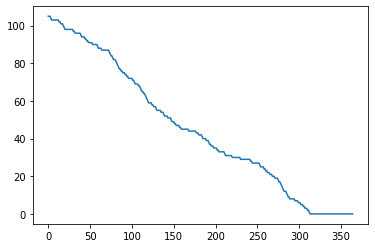

In [7]:
coach_seats,coach_revenue=simulate_revenue(flight_specifics['coach'])
plt.plot(coach_seats)


# np.where(coach_seats==5)
# np.max(coach_seats)
np.where(coach_seats==0)[0][0],np.where(coach_seats==5)[0][0]

seats_left= 10.0


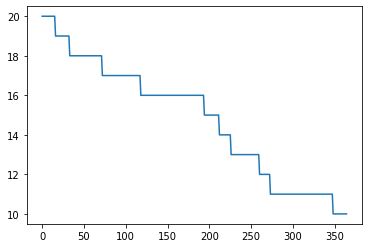

In [8]:
firstClass_seats,firstClass_revenue=simulate_revenue(flight_specifics['firstClass'])
plt.plot(firstClass_seats)

try:
  np.where(firstClass_seats==0)[0][0]
except:
  print(f'seats_left= {firstClass_seats[-1]}')

# Combinatorial Approach 

In [19]:
overbooking_allowed=5

def expected_cost(firstClass_passengers,coach_passengers):
  if coach_passengers<=100:
    return 0
  else:
    excess_passenger=coach_passengers-100
    if excess_passenger>overbooking_allowed:
      excess_passenger=overbooking_allowed
    
    # excess_passenger=max(overbooking_allowed,excess_passenger)

    firstClass_seats_left=max(0,20-firstClass_passengers)
    #I will prefer while loop here but let us calculate 

    passengers_transferred=min(excess_passenger,firstClass_seats_left)
    passengers_notFlying=max(0,excess_passenger-passengers_transferred)
    cost=425*passengers_notFlying + 50*passengers_transferred
    return cost

expected_cost(20,90),expected_cost(10,102),expected_cost(10,115),expected_cost(10,150),expected_cost(20,102),expected_cost(20,110)#Maximum would be when I will have to send back all the five(overbooked) passengers

(0, 100, 250, 250, 850, 2125)

In [22]:
import numpy.random as npr
from scipy.stats import binom

#All possible passengers state that is coach passenger , first class passenger--> All possible combination of coach passenger and first class passenger possible for that state and their expected value

expected_value=[]
# for coach_passenger_state in range(flight_specifics['coach']['seats']+flight_specifics['coach']['overbooking']+1):
#   for firstClass_passenger_state in range(flight_specifics['firstClass']['seats']+1):

#because all other values below 100 will give associated cost as 0, so we dont need to run our loop through them
for coach_passenger_state in range(flight_specifics['coach']['seats']+1,flight_specifics['coach']['seats']+flight_specifics['coach']['overbooking']+1):
  for firstClass_passenger_state in range(flight_specifics['firstClass']['seats']+1):

    for coach_passenger in range(coach_passenger_state+1):
      for firstClass_passenger in range(firstClass_passenger_state+1):
        #Events are independent thus the probabilities can be computed separately and then multiplied
        prob_coach_passenger=binom.pmf(n=coach_passenger_state,
                                       p=0.95,
                                       k=coach_passenger)
        prob_firstClass_passenger=binom.pmf(n=firstClass_passenger_state,
                                       p=0.97,
                                       k=firstClass_passenger)
        associated_cost=expected_cost(firstClass_passenger,coach_passenger)
        
        event_value=associated_cost*(prob_coach_passenger*prob_firstClass_passenger)

        expected_value.append(event_value)





# def calculate_probability()
# binom.pmf(n=,p=0.5,k=1)





In [30]:
overbooking_coach=5
overbooking_firstClass=0

flight_specifics={
    'coach': dict(
        priceL = {'Y':300,
                  'N':0
                  }, 
        priceH = {'Y':350,
                  'N':0
                  },
        pL = {
            'Y':0.65,
            'N':0.35
              }, 
        pH = {
            'Y':0.3,
            'N':0.7
              }, 
        seats=100,
        days=365,
        overbooking=overbooking_coach
        ),

    'firstClass':dict(
        priceL = {'Y':425,
                  'N':0
                  },
        priceH = {'Y':500,
                  'N':0
                  },
        pL = {
            'Y':0.08,
            'N':0.92
              },
        pH = {
            'Y':0.04,
            'N':0.96
              },
        seats=20,
        days=365,
        overbooking=overbooking_firstClass        
                    )}
pd.DataFrame(flight_specifics)

,coach,firstClass
priceL,"{'Y': 300, 'N': 0}","{'Y': 425, 'N': 0}"
priceH,"{'Y': 350, 'N': 0}","{'Y': 500, 'N': 0}"
pL,"{'Y': 0.65, 'N': 0.35}","{'Y': 0.08, 'N': 0.92}"
pH,"{'Y': 0.3, 'N': 0.7}","{'Y': 0.04, 'N': 0.96}"
seats,100,20
days,365,365
overbooking,5,0


In [31]:
import copy
dict_specific=copy.deepcopy(flight_specifics)
pd.DataFrame(dict_specific)

,coach,firstClass
priceL,"{'Y': 300, 'N': 0}","{'Y': 425, 'N': 0}"
priceH,"{'Y': 350, 'N': 0}","{'Y': 500, 'N': 0}"
pL,"{'Y': 0.65, 'N': 0.35}","{'Y': 0.08, 'N': 0.92}"
pH,"{'Y': 0.3, 'N': 0.7}","{'Y': 0.04, 'N': 0.96}"
seats,100,20
days,365,365
overbooking,5,0


In [ ]:
# def call_probabilities(price_setting)

In [41]:
delta = (1/(1+15/365))

T = dict_specific['coach']['days'] #365

overbooking=dict_specific['coach']['overbooking']
seats_coach = dict_specific['coach']['seats'] + overbooking
seats_firstClass=dict_specific['firstClass']['seats']

#Lets define placeholders
V = np.zeros((seats_coach+1,seats_firstClass+1,T+1)) #0,1......365
U = np.zeros((seats_coach+1,seats_firstClass+1,T+1)) 

V[:,:,T] =sum(expected_value)#at t=365
U[:,:,T] =0

for t in reversed(range(T-1)):
  for c_s in range(seats_coach+1):#go till 100+5 therefore +1
    for fc_s in range(seats_firstClass+1):

      if c_s==0: 
        V[c_s,fc_s,t]=0 
        U[c_s,fc_s,t]=-1 #4 choices HH,Hl,LH,LL 
      elif fc_s==0:
        V[c_s,fc_s,t]=0 
        U[fc_s,fc_s,t]=-2 #4 choices HH,Hl,LH,LL 
      else:
        #Design Matrix for four choices 
        #nomenclatureConvention --> coach_firstClass
        val_choices=[]
        for price_choice in ['HH','HL','LH','LL']: 

          ch_coach=price_choice[0]
          ch_firstClass=price_choice[1]

          prob_dict_1=dict_specific['coach']['p'+ch_coach]
          rev_dict_1=dict_specific['coach']['price'+ch_coach]

          prob_dict_2=dict_specific['firstClass']['p'+ch_firstClass]
          rev_dict_2=dict_specific['firstClass']['price'+ch_firstClass]

          boughtTicket_choices=('YY','YN','NY','NN')

          dict_bool={
              'Y':1,
              'N':0
          }

          expected_revenue=0
          for choices in boughtTicket_choices:
            temp_1=choices[0]
            temp_2=choices[1]

            coach_ticket_sold=dict_bool[temp_1]
            firstClass_ticket_sold=dict_bool[temp_2]


            temp_revenue_reward=rev_dict_1[temp_1]+rev_dict_2[temp_2]
            temp_prob=prob_dict_1[temp_1]*prob_dict_2[temp_2]

            temp_temporal_reward=delta*V[c_s-coach_ticket_sold,fc_s-firstClass_ticket_sold,t+1]#0

            temp_reward=temp_revenue_reward*temp_prob + temp_temporal_reward*temp_prob

            expected_revenue+= temp_reward
          val_choices.append(expected_revenue)


      V[c_s,fc_s,t]=max(val_choices) 
      U[c_s,fc_s,t]=np.argmax(val_choices)+1 


In [43]:
V

array([[[5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        ...,
        [5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376]],

       [[5801.33051941, 5801.33040385, 5801.33028358, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051955, 5801.33040403, 5801.33028379, ...,
          229.        ,    0.        , 1906.12287376],
        [5801.33051955, 5801.33040404, 5801.3302838 , ...,
          229.

In [ ]:
def generate_choiceLattice(dict_specific,delta=1/(1+15/365)):
  priceL = dict_specific['priceL']
  priceH = dict_specific['priceH']
  pL = dict_specific['pL']
  pH = dict_specific['pH']

  delta = delta

  overbooking=dict_specific['overbooking']
  M = dict_specific['seats'] + overbooking
  T = dict_specific['days'] 

  sValues = np.arange(M+1) 
  tValues = np.arange(T+1) 
  sN = len(sValues)
  tN = len(tValues)

  V = np.zeros((sN,tN)) 
  U = np.zeros((sN,tN)) 

  V[:,tN-1] = 0 
  U[:,tN-1] =0

  for t in reversed(range(tN-1)):
    for s in range(sN):
      if s==0: 
        V[s,t]=0 
        U[s,t]=3 
      else:
        valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
        valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

        V[s,t]=max(valueL,valueH) 
        U[s,t]=np.argmax([valueL,valueH])+1 
  return (V,U)


v,u=generate_choiceLattice(flight_specifics['coach'])
flight_specifics['coach']['v']=v
flight_specifics['coach']['u']=u


v,u=generate_choiceLattice(flight_specifics['firstClass'])
flight_specifics['firstClass']['v']=v
flight_specifics['firstClass']['u']=u


# flight_specifics
# flight_specifics['firstClass']['v'].shape

In [25]:
associated_cost
firstClass_passenger
coach_passenger

105

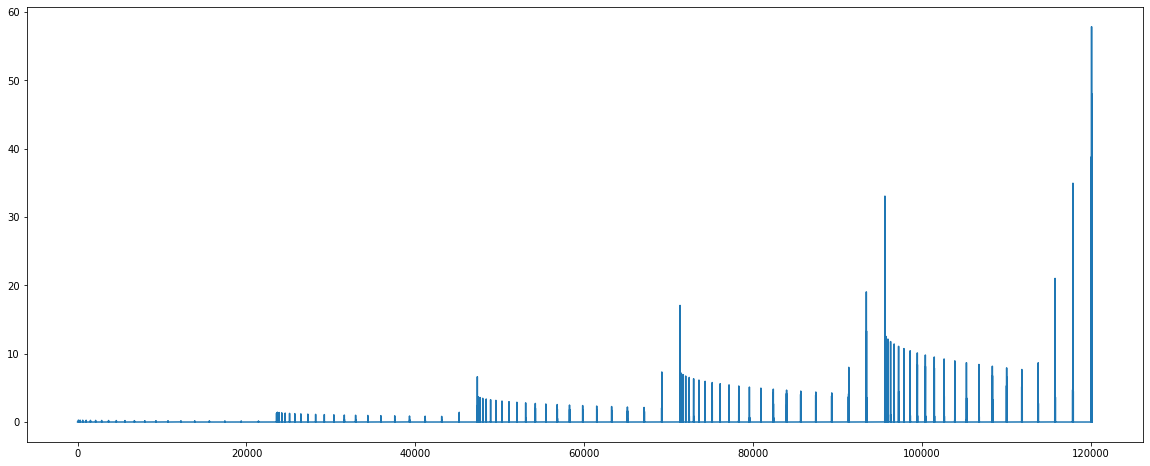

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(expected_value)

In [24]:
sum(expected_value)

1906.1228737633585

# ROUGH SPACE

In [ ]:
V = np.zeros((sN,tN)) 
U = np.zeros((sN,tN)) 

# boundary/terminal condition
V[:,tN-1] = 0 # when the flight takes off you can't make any more money
U[:,tN-1] = 0 # 0 is the value for no tickets for sale


In [ ]:
for t in reversed(range(tN-1)):
    for s in range(sN):
        if s==0: 
            V[s,t]=0 
            U[s,t]=3 
        else:
            valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
            valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

            V[s,t]=max(valueL,valueH) 
            U[s,t]=np.argmax([valueL,valueH])+1 


In [ ]:
U[:10]

In [ ]:
# U[
# np.where(U==3)
  # ]
from copy import deepcopy

v_coach=deepcopy(V)
u_coach=deepcopy(U)


In [ ]:
priceL = 425
priceH = 500
pL = [0.08,0.92] 
pH = [0.04,0.96] 

delta = 1/(1+15/365) #0.96

overbooking=0
M = 20 + overbooking
T = 365 

sValues = np.arange(M+1) #0 and other seats that are allowed
tValues = np.arange(T+1) 
sN = len(sValues)
tN = len(tValues)

In [ ]:
for t in reversed(range(tN-1)):
    for s in range(sN):
        if s==0: 
            V[s,t]=0 
            U[s,t]=3 
        else:
            valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
            valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

            V[s,t]=max(valueL,valueH) 
            U[s,t]=np.argmax([valueL,valueH])+1 


In [ ]:
U

In [ ]:
v_firstClass=deepcopy(V)
u_firstClass=deepcopy(U)

In [ ]:
1/(1+15/365)

In [ ]:
np.flip(np.arange(0,-5,-1))

In [ ]:
# expectedValue_revenue

# HH

val_choices=[]
for price_choice in ['HH','HL','LH','LL']: 

  ch_coach=price_choice[0]
  ch_firstClass=price_choice[1]

  prob_dict_1=dict_specific['coach']['p'+ch_coach]
  rev_dict_1=dict_specific['coach']['price'+ch_coach]

  prob_dict_2=dict_specific['firstClass']['p'+ch_firstClass]
  rev_dict_2=dict_specific['firstClass']['price'+ch_firstClass]

  boughtTicket_choices=('YY','YN','NY','NN')

  dict_bool={
      'Y':1,
      'N':0
  }

  expected_revenue=0
  for choices in boughtTicket_choices:
    temp_1=choices[0]
    temp_2=choices[1]

    coach_ticket_sold=dict_bool[temp_1]
    firstClass_ticket_sold=dict_bool[temp_2]


    temp_revenue_reward=rev_dict_1[temp_1]+rev_dict_2[temp_2]
    temp_prob=prob_dict_1[temp_1]*prob_dict_2[temp_2]

    temp_temporal_reward=0#delta*V[c_s-coach_ticket_sold,fc_s-firstClass_ticket_sold,t+1]#0

    temp_reward=temp_revenue_reward*temp_prob + temp_temporal_reward*temp_prob

    expected_revenue+= temp_reward
  val_choices.append(expected_revenue)




# prob_dict_2,rev_dict_2
max(val_choices)
np.argmax(val_choices)